# The Green's function approach
#### Use Jacobian matrices ($J_x$) and SST patterns ($\Delta SST_j$) to reconstruct model-simulated climate respones ($\Delta X_i$)


$$
\begin{align}
\Delta X_i = \sum_{j=1}^{n} \frac{\partial X_i}{\partial SST_j} \Delta SST_j + \epsilon_X \\
\\
\\
J_X      = \frac{\partial X_i}{\partial {SST}_j} = \begin{bmatrix} \frac{\partial X_1}{\partial {SST}_1} & ... & \frac{\partial X_1}{\partial {SST}_n} \\ ... & ... & ... \\ \frac{\partial X_n}{\partial {SST}_1} & ... & \frac{\partial X_n}{\partial {SST}_n} \end{bmatrix}
\\
\\
\end{align}
$$


#### SST patterns ($\Delta SST_j$) is a one-dimension array and can be reshaped as a two-dimension array (lat, lon)

1. read any SST you have
2. remove monthly climatology to get SST anomaly (here use 1870-1899 as climatology)
3. regrid to latxlon by atmos.static.nc (2°x2.5°). lat is from -89 to 89, lon is 1.25, 3.75 .. , 358.75
4. replace missing value with 0.0 (e.g. grid points over land), this is important

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
%matplotlib inline

#### lat and lon info
#### SST must be on the grid provded by atmos.static.nc

In [2]:
# reading lat lon infomation
ds_coords = xr.open_dataset('/work/Bosong.Zhang/jaco_public/low_reso_A4p0/example/'+'atmos.static.nc')
land = ds_coords['land_mask']
# print(land.shape)
lat = ds_coords['lat']
lon = ds_coords['lon']
lon

<xarray.DataArray 'lon' (lon: 144)>
array([  1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75,
        91.25,  93.75,  96.25,  98.75, 101.25, 103.75, 106.25, 108.75, 111.25,
       113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75,
       136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25,
       158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75,
       181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75, 201.25,
       203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75, 221.25, 223.75,
       226.25, 228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75, 246.25,
       248.75, 251.25, 253.75, 256.25, 258.75, 261.25, 263.75, 266.25, 268.75,
       271.25, 273.75, 276.25, 278.75, 281.25, 283.75, 286.25, 288.75, 291.25,
       293.75, 296.25, 298.75, 301.25, 303.75, 306.25, 308.75, 311.25, 313.75,
       316.25, 318.75, 321.25, 323.75, 326.25, 328.75, 331.25, 333.75, 336.25,
       338.75, 341.25, 343.75, 346.25, 348.75, 351.25, 353.75, 356.25, 358.75])
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Attributes:
    long_name:  longitude
    units:      degrees_E
    axis:       X
    bounds:     lon_bnds

In [3]:
ds0_model = xr.open_dataset('/work/Bosong.Zhang/jaco_public/low_reso_A4p0/example/'+f'atmos.187001-201412.olr.nc')
ds1_model = xr.open_dataset('/work/Bosong.Zhang/jaco_public/low_reso_A4p0/example/'+f'atmos.187001-201412.swdn_toa.nc')
ds2_model = xr.open_dataset('/work/Bosong.Zhang/jaco_public/low_reso_A4p0/example/'+f'atmos.187001-201412.swup_toa.nc')

var0 = ds0_model['olr']
var1 = ds1_model['swdn_toa']
var2 = ds2_model['swup_toa']

var_R = var1 - var2 - var0

In [4]:
ds0_model['time']
var_R_clm = var_R.loc['1870-01':'1899-12',:,:].groupby('time.month').mean(dim=['time'])

# var_R_clm.coords['time']
var_R_anom = var_R.groupby('time.month') - var_R_clm

In [5]:
# var_R.loc['1870-01':'1899-12',:,:].groupby('time.day').mean(dim=['time'])

In [6]:
varname   = 'R'
files_1   = '/work/Bosong.Zhang/jaco_public/low_reso_A4p0/'\
                f'jaco.{varname}_i_over_j_*.nc'

tmp=subprocess.run(["ls "+files_1], shell=True, capture_output=True)

filelist=tmp.stdout.decode("utf-8").splitlines()
# print(filelist)
ds = xr.open_mfdataset(filelist,parallel=True, combine='nested',concat_dim=['month'])
jaco = ds['jaco']
jaco

<xarray.DataArray 'jaco' (month: 12, ii: 12960, jj: 12960)>
dask.array<concatenate, shape=(12, 12960, 12960), dtype=float32, chunksize=(1, 12960, 12960), chunktype=numpy.ndarray>
Coordinates:
  * ii       (ii) int32 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * jj       (jj) int32 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: month

In [7]:
# read Δ𝑆𝑆𝑇𝑗
ds1 = xr.open_dataset('/work/Bosong.Zhang/jaco_public/low_reso_A4p0/example/'+'low_reso_sst_final_187001-201412.nc')
sst = ds1['sst_final']
print(sst.shape)
sst3d = sst.values.reshape((145,12,12960)) # 145 years x 12 months x jj

(1740, 90, 144)


In [8]:
var_reconst = np.empty([12960,145,12]) # ii x 145 years x 12 months

In [9]:
%%time
for i in range(12):
    print(i)
    sst_this_month = sst3d[:,i,:]
    sst_reorder = np.moveaxis(sst_this_month,0,-1)
    # print(sst_reorder.shape)
    var_reconst[:,:,i] = np.matmul(jaco[i,:,:].values, sst_reorder)
    # print(var_reconst.shape)

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 17.7 s, sys: 12.6 s, total: 30.3 s
Wall time: 30.8 s


In [10]:
def global_mean_xarray_nan(ds_XLL):
    """ By C.Wang
    A function to compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    
    Parameters
    ----------
    ds_XLL   :  DataArray with lat and lon. ds_XLL.lat will be 
                used for area weight.

    Returns
    ----------
    GM_mean  : global mean value.
    
    """
    lat = ds_XLL.coords['lat']        # readin lat
    weight_area = np.cos(np.deg2rad(lat))
    data_XLL_weighted = (ds_XLL*weight_area).mean(dim=['lat','lon'])
    data_ones_nan = xr.where(np.isfinite(ds_XLL),1.,np.nan)
    weight_sum = (data_ones_nan*weight_area).mean(dim=['lat','lon'])
    GM_mean = data_XLL_weighted/weight_sum

    return GM_mean

In [11]:
year = np.arange(145)
month = np.arange(12)
var3d = var_reconst.reshape((90,144,145,12))
var3d_da = xr.DataArray(var3d, coords=[lat, lon, year, month], dims=["lat", "lon", "year","month"])
var3d_gm = global_mean_xarray_nan(var3d_da)
var3d_final = var3d_gm.mean(dim=['month'])

In [12]:
var_R_anom_gm = global_mean_xarray_nan(var_R_anom)
var_R_anom_new = var_R_anom_gm.values.reshape((145,12))
var_R_anom_new
# var_R_anom_da = xr.DataArray(var_R_anom_new, coords=[year, month], dims=["year","month"])
var_R_anom_final = var_R_anom_new.mean(axis=1)
var_R_anom_final.shape

(145,)

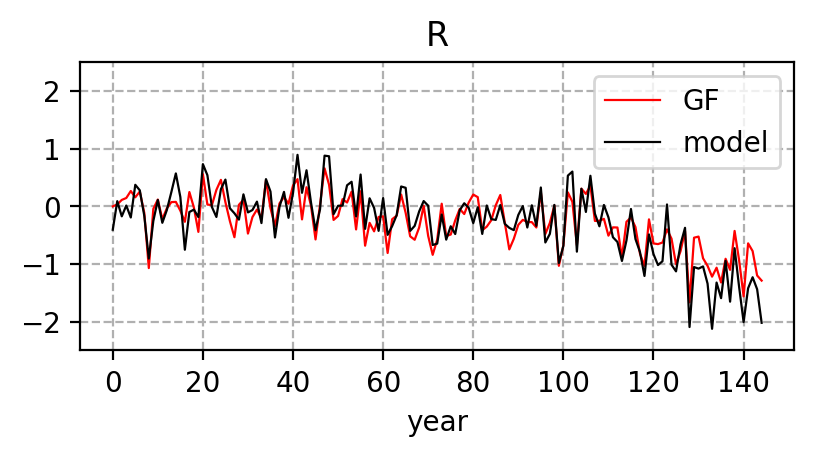

In [13]:
plt.close()
fig1 = plt.figure(figsize=(8,6),dpi=200)
ax1 = fig1.add_subplot(321)

ax1.plot(year,var3d_final,label = 'GF',  color='red', linewidth=.8)
ax1.plot(year,var_R_anom_final,label = 'model',  color='black', linewidth=.8)
plt.title('R')
ax1.set_xlabel('year')

ax1.set_ylim(-2.5,2.5)
ax1.grid(linestyle='--')
ax1.legend()

plt.tight_layout()
plt.show()